In [ ]:
#Installing the required library
!pip install tensorflow==2.10.0
!pip install numpy==1.23.4
!pip install pandas==1.5.2
!pip install scikit-learn==1.1.3
!pip install rdkit

In [2]:
# Data processing and visualizationlibrary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches
# Tensorflow and keras library
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, TensorBoard
from keras.models import load_model
# ScikitLearn library
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
# Misc
import sys
import os
import random
from unicodedata import name
from datetime import datetime

#Molecule picture generation library
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image, ImageDraw, ImageFont

print("To ensure repeatability, use the following setup:")
print("TensorFlow version:", "2.10.0")
print("Numpy version:", '1.23.4')
print("Pandas version:", '1.5.2')
print("SKLearn version:", "1.1.3")
print("Python version:", "3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]")
print("==============================")
print("Your current library version:")
print("TensorFlow version:", tf.__version__)
print("Numpy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("SKLearn version:", sklearn.__version__)
print("Python version:",sys.version)

To ensure repeatability, use the following setup:
TensorFlow version: 2.10.0
Numpy version: 1.23.4
Pandas version: 1.5.2
SKLearn version: 1.1.3
Python version: 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]
Your current library version:
TensorFlow version: 2.10.0
Numpy version: 1.23.4
Pandas version: 1.5.2
SKLearn version: 1.1.3
Python version: 3.8.6 (tags/v3.8.6:db45529, Sep 23 2020, 15:52:53) [MSC v.1927 64 bit (AMD64)]


In [96]:
# Get the current directory
current_directory = os.getcwd()
# Construct the relative path to the CSV file
csv_filename1 = 'datasetscsv/trainval_set.csv' #Training-validation datasets
csv_filename2 = 'datasetscsv/test_set.csv' #Unseen test set
csv_filename3 = 'datasetscsv/master_dataset.csv' #Combined train-validation-test set
csv_filename4 = 'datasetscsv/allMolecule.csv' #Molecule only set
csv_path1 = os.path.join(current_directory, csv_filename1)
csv_path2 = os.path.join(current_directory, csv_filename2)
csv_path3 = os.path.join(current_directory, csv_filename3)
csv_path4 = os.path.join(current_directory, csv_filename4)
seed = 21
random.seed(seed)

model_name = 'Model/SWISH_WnD.h5'
model_path = os.path.join(current_directory, model_name)
folder_name = 'Visual/Molecule_pic/Tertiary_alkanolamines_analysis'
folder_path = os.path.join(current_directory, folder_name)

In [97]:
# Importing dataset
trainval_df = pd.read_csv(csv_path1, names=["Molecule", "Formula","SMILES","Type","Cyclicity",
                                       "Primary counts","Secondary counts","Tertiary counts",
                                       "Hydroxyl counts","Carboxyl counts","Oxyl counts",
                                       "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
                                       "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
                                       "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
                                       "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
                                       "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
                                       "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
                                       "MW","Partial Pressure","Temperature",
                                       "Amine Concentration", "Absorption Capacity", "References","Rounded Concentration", "Abbreviation"]) 
test_df     = pd.read_csv(csv_path2, names=["Molecule", "Formula","SMILES","Type","Cyclicity", 
                                       "Primary counts","Secondary counts","Tertiary counts",
                                       "Hydroxyl counts","Carboxyl counts","Oxyl counts",
                                       "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
                                       "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
                                       "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
                                       "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
                                       "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
                                       "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
                                       "MW","Partial Pressure","Temperature",
                                       "Amine Concentration", "Absorption Capacity", "References","Rounded Concentration", "Abbreviation"]) 
# PREPROCESSING
X_test_label = test_df.drop(columns=["Absorption Capacity"])
y_test = test_df['Absorption Capacity']

X_trainval_label =  trainval_df.drop(columns=["Absorption Capacity"])
y_trainval_label = trainval_df['Absorption Capacity']

# DATA SPLITING
X_train, X_val, y_train, y_val = train_test_split(X_trainval_label, y_trainval_label, test_size=0.20, random_state=seed)

# Reserve the dataset for visualization
X_train_1 = X_train.copy()
X_val_1 = X_val.copy()
X_reserved = pd.concat([X_train_1, X_val_1, X_test_label], axis=0)

# DROPPING STRINGS AND DATA PREPROCESSING
X_train = X_train.drop(columns=["Molecule", "Formula", "SMILES", "Type", "Cyclicity", "References", "Rounded Concentration", "Abbreviation"])
X_test = X_test_label.drop(columns=["Molecule", "Formula", "SMILES", "Type", "Cyclicity", "References", "Rounded Concentration", "Abbreviation"])
X_val = X_val.drop(columns=["Molecule", "Formula", "SMILES", "Type", "Cyclicity", "References", "Rounded Concentration", "Abbreviation"])

feature_names = X_train.columns.tolist()
preprocessor = Pipeline(steps=[('step1', StandardScaler())])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = pipeline.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=feature_names)

X_val = pipeline.transform(X_val)
X_val = pd.DataFrame(X_val, columns=feature_names)

X_test = pipeline.transform(X_test)
X_test = pd.DataFrame(X_test, columns=feature_names)

master_df = pd.read_csv(csv_path3, 
    names=["Molecule","Formula","SMILES","Type","Cyclicity",
           "Primary counts","Secondary counts","Tertiary counts",
           "Hydroxyl counts","Carboxyl counts","Oxyl counts",
           "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
           "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
           "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
           "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
           "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
           "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
           "MW","Partial Pressure","Temperature",
           "Amine Concentration", "Absorption Capacity", "References","Rounded Concentration","Abbreviation"]) 
scaler = preprocessor.named_steps['step1']
mean_values = scaler.mean_[27] # pressure structure
std_values = scaler.scale_[27] # pressure structure

len(X_train)

2383

In [98]:
#loading the model and operating condition initialization
model = load_model(model_path)
size = 1
fold = 1
T_ref = 303.15
T_tar = 313.15
percent_vol_CO2 = 0.15
Part_pres = 100
PCO2                       = np.ones(size)*Part_pres # PARTIAL PRESSURE IN kPa
T                          = np.ones(size)*T_tar # TEMPERATURE IN KELVIN'
C                          = np.ones(size)*2.5  #CONCENTRATION IN MOLAR

Molecule_var = pd.read_csv(csv_path4, names=["Molecule", "Formula","SMILES","Type","Cyclicity",
                                       "Primary counts","Secondary counts","Tertiary counts",
                                       "Hydroxyl counts","Carboxyl counts","Oxyl counts",
                                       "M0(nhb)", "M0(oh)", "M0(nh)", "M0(op)", 
                                       "M1(nhb_donor)", "M1(nhb_weak)", "M1(nhb_acceptor)",
                                       "M1(oh_donor)", "M1(oh_weak)","M1(oh_acceptor)",
                                       "M1(nh_donor)", "M1(nh_weak)", "M1(nh_acceptor)",
                                       "M1(op_donor)", "M1(op_weak)", "M1(op_acceptor)",
                                       "M2(nhb)", "M2(oh)", "M2(nh)","M2(op)",
                                       "MW", "Abbreviation"]) 

In [99]:
pred_alpha = []
for i in range(len(Molecule_var)):
    species = i
    # Create Prediction Set
    Prediction_set= pd.DataFrame(data={
                #DESCRIPTOR
                'Primary counts'                   : np.ones(size)*Molecule_var.iloc[species]['Primary counts'],
                'Secondary counts'                 : np.ones(size)*Molecule_var.iloc[species]['Secondary counts'],
                'Tertiary counts'                  : np.ones(size)*Molecule_var.iloc[species]['Tertiary counts'],
                'Hydroxyl counts'                  : np.ones(size)*Molecule_var.iloc[species]['Hydroxyl counts'],
                'Carboxyl counts'                  : np.ones(size)*Molecule_var.iloc[species]['Carboxyl counts'],
                'Oxyl counts'                      : np.ones(size)*Molecule_var.iloc[species]['Oxyl counts'],
                'M0(nhb)'                          : np.ones(size)*Molecule_var.iloc[species]['M0(nhb)'],
                'M0(oh)'                           : np.ones(size)*Molecule_var.iloc[species]['M0(oh)'],
                'M0(nh)'                           : np.ones(size)*Molecule_var.iloc[species]['M0(nh)'],
                'M0(op)'                           : np.ones(size)*Molecule_var.iloc[species]['M0(op)'],
                'M1(nhb_donor)'                    : np.ones(size)*Molecule_var.iloc[species]['M1(nhb_donor)'],
                'M1(nhb_weak)'                     : np.ones(size)*Molecule_var.iloc[species]['M1(nhb_weak)'],
                'M1(nhb_acceptor)'                 : np.ones(size)*Molecule_var.iloc[species]['M1(nhb_acceptor)'],
                'M1(oh_donor)'                     : np.ones(size)*Molecule_var.iloc[species]['M1(oh_donor)'],
                'M1(oh_weak)'                      : np.ones(size)*Molecule_var.iloc[species]['M1(oh_weak)'],
                'M1(oh_acceptor)'                  : np.ones(size)*Molecule_var.iloc[species]['M1(oh_acceptor)'],
                'M1(nh_donor)'                     : np.ones(size)*Molecule_var.iloc[species]['M1(nh_donor)'],
                'M1(nh_weak)'                      : np.ones(size)*Molecule_var.iloc[species]['M1(nh_weak)'],
                'M1(nh_acceptor)'                  : np.ones(size)*Molecule_var.iloc[species]['M1(nh_acceptor)'],
                'M1(op_donor)'                     : np.ones(size)*Molecule_var.iloc[species]['M1(op_donor)'],
                'M1(op_weak)'                      : np.ones(size)*Molecule_var.iloc[species]['M1(op_weak)'],
                'M1(op_acceptor)'                  : np.ones(size)*Molecule_var.iloc[species]['M1(op_acceptor)'],
                'M2(nhb)'                          : np.ones(size)*Molecule_var.iloc[species]['M2(nhb)'],
                'M2(oh)'                           : np.ones(size)*Molecule_var.iloc[species]['M2(oh)'],                
                'M2(nh)'                           : np.ones(size)*Molecule_var.iloc[species]['M2(nh)'],
                'M2(op)'                           : np.ones(size)*Molecule_var.iloc[species]['M2(op)'],
                'MW'                               : np.ones(size)*Molecule_var.iloc[species]['MW'],
                #OPERATING CONDITION
                'Partial Pressure'                 : PCO2, #x axis in 3d plot
                'Temperature'                      : T, #y axis in 3d plot
                'Amine Concentration'              : C            
                })

    Prediction_set_new = pipeline.transform(Prediction_set)
    column_names = Prediction_set.columns.tolist()
    Prediction_set_new = pd.DataFrame(Prediction_set_new, columns=column_names)

    #Prediction
    z_pred = model.predict(Prediction_set_new, verbose=0)
    pred_alpha.append(z_pred)
pred_alpha_reshaped = np.array(pred_alpha).reshape(len(Molecule_var), 1)
pr_load = pd.DataFrame(pred_alpha_reshaped,columns=['Predicted loading'])
result = pd.concat([Molecule_var,pr_load], axis=1)

In [100]:
#Choose molecule to compare. Refer to variable 'Molecule_var' for abbreviation of each
molanalysis = ['BDEA','EDEA','MDEA','HEEAB']
emset = []
for i in range(len(molanalysis)):
    w = result[result['Abbreviation'] == molanalysis[i]]
    emset.append(w)
dfnew = pd.concat(emset, ignore_index=False)
dfnew

,Molecule,Formula,SMILES,Type,Cyclicity,Primary counts,Secondary counts,Tertiary counts,Hydroxyl counts,Carboxyl counts,...,M1(op_donor),M1(op_weak),M1(op_acceptor),M2(nhb),M2(oh),M2(nh),M2(op),MW,Abbreviation,Predicted loading
114,butyldiethanolamine,C8H19NO2,CCCCN(CCO)CCO,Tertiary,No,0,0,1,2,0,...,0,0.0,0.0,0.002670,0.004683,0.000443,0.0,161.242,BDEA,0.594066
98,N-ethyldiethanolamine,C6H15NO2,CCN(CCO)CCO,Tertiary,No,0,0,1,2,0,...,0,0.0,0.0,0.002741,0.005336,0.000462,0.0,133.189,EDEA,0.680177
45,methyldiethanolamine,C5H13NO2,CN(CCO)CCO,Tertiary,No,0,0,1,2,0,...,0,0.0,0.0,0.002555,0.005438,0.000584,0.0,119.162,MDEA,0.729501
73,4-((2-hydroxyethyl)(ethyl)amino)-2-butanol,C8H19NO2,CC(CCN(CCO)CC)O,Tertiary,No,0,0,1,2,0,...,0,0.0,0.0,0.002830,0.005072,0.000673,0.0,161.242,HEEAB,0.812570


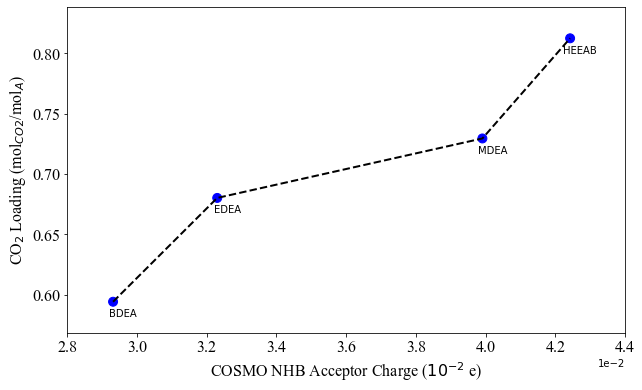

In [101]:
csfont = {'fontname': 'Times New Roman'}
fontsize = 16
markersize = 80
X = dfnew.drop(columns=["Molecule","Formula","SMILES","Type","Cyclicity","Abbreviation","Predicted loading"])
X = X.reset_index(drop=True)
y = dfnew['Predicted loading'].reset_index(drop=True)
names = dfnew['Abbreviation'].reset_index(drop=True)

# Perform PCA
plt.figure(figsize=(10, 6))
pca = PCA(n_components=2)
PC = pca.fit_transform(X)

type_to_color = {
    'Primary': 'red',
    'Secondary': 'green',
    'Tertiary': 'blue',
    'Polyamine': 'purple'
}
x = X['M1(nh_acceptor)']
# Generating an array of colors for each data point
colors = [type_to_color[type_] for type_ in dfnew['Type']]
plt.scatter(x, y, c=colors, s=markersize, marker='o')  
plt.plot(x,y, linestyle='--', color='black', linewidth=2)
# Adding annotations for each data point
for i, name in enumerate(names):
    plt.annotate(name, (x[i], y[i]), textcoords="offset points", xytext=(10,-15), ha='center')

# Customize the plot
plt.xlabel("COSMO NHB Acceptor Charge ($10^{-2}$ e)", **csfont, fontsize=fontsize)
plt.ylabel('CO$_{2}$ Loading (mol$_{CO2}$/mol$_{A}$)', **csfont, fontsize=fontsize)
plt.xticks(fontname='Times New Roman', fontsize=fontsize)
plt.yticks(fontname='Times New Roman', fontsize=fontsize)
plt.xlim(2.8e-2, 4.4e-2)
plt.ticklabel_format(style='scientific', axis='x', scilimits=(0, 0))
#Å²
plt.show()

In [102]:
#Generating molecule picture
for i in range(len(dfnew)):

    smiles_code = dfnew.iloc[i]['SMILES']
    molecule_name = dfnew.iloc[i]['Molecule']
    predicted_loadings = round(dfnew.iloc[i]['Predicted loading'], 2)
    predicted_loading = predicted_loadings
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles_code)

    # Check if the conversion was successful
    # Generate a 2D depiction of the molecule
    img = Draw.MolToImage(mol)

    # Add the molecule name as a text label
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("times.ttf", 20)  # Change the font and size as needed
    text = f'{predicted_loading}'
    text_width, text_height = draw.textsize(text, font)
    x = (img.width - text_width) // 2
    y = img.height - text_height - 5
    if y < 0:  # If the text would go above the image, adjust its position
        y = 0
    draw.text((x, y), text, fill="black", font=font)

    # Display the image
    #img.show()

    folder_name = f"{folder_name}"
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    file_name = f"{dfnew.iloc[i]['Molecule']}_{dfnew.iloc[i]['Abbreviation']}.png"
    file_path = os.path.join(folder_name, file_name)
    img.save(file_path)

C:\Users\WAHYU\AppData\Local\Temp\ipykernel_276\3621579890.py:22: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font)
C:\Users\WAHYU\AppData\Local\Temp\ipykernel_276\3621579890.py:22: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font)
C:\Users\WAHYU\AppData\Local\Temp\ipykernel_276\3621579890.py:22: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font)
C:\Users\WAHYU\AppData\Local\Temp\ipykernel_276\3621579890.py:22: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font)
